# Análisis de sentimientos usando RNN

Hoy en día, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar el texto contenido en comentarios u opiniones (*review*) sobre una película para determinar su polaridad, es decir, determinar si reﬂeja un sentiemiento positivo o negativo. Usaremos el *Large Movie Review Dataset*, también conocido como *IMDB dataset* que contiene **50000 comentarios** de películas etiquetadas como buenas o malas (50%-50% train-testing).

------------------

## Librerias


In [5]:
import keras
import numpy as np

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from matplotlib import pyplot as plt

----------------------

### Carga de Datos

Se utiliza la base de datos de imdb, la cual mediante la funcion *load_data* produce conjuntos separados por tuplas.


In [3]:
np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="B:\Programas\Google Drive\USM\Redes Neuronales\Tarea 3\datasets\imdb.npz",seed=15)

-------------
### Estudio de distribución


In [4]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Ahora que tenemos los datos cargados y listos para ser analizados, veremos su forma, la cantidad de clases que tiene, el número de palabras. De aquí esperamos que el contenido sea de *(50000, None)* dadas las especificaciones en la [Documentación de keras imdb](https://keras.io/datasets/), además estas podrán ser *"buenas"* o *"malas"* lo que nos indice a pensar que será un comportamiento binario el número de clases. 

Training data:
(50000,) 
(50000,)

Clases:
[0 1]

Review lenght: 


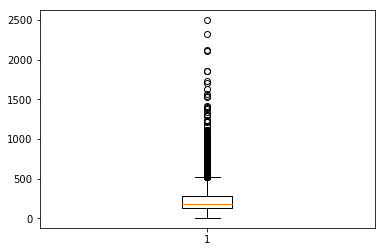

In [5]:
print "Training data:\n", X.shape, "\n", y.shape

print "\nClases:\n", np.unique(y)

print "\nReview lenght: "
result = map(len, X)
plt.boxplot(result)
plt.show()

Podemos notar la alta concentración en comentarios con menos de 500 palabras, teniendo una media de *234.75892* palabras y una desviación estandar de *172.91149*. (Ambos datos obtenidos a través de **np.mean** y **np.std**). Ahora bien para analizar las palabras aprovechares la indexación que viene en este dataset. Se muestran algunos gráficos que corresponden a los datos obtenidos mediante **np.unique(ds, return_counts=True)**. Tomando en cuenta que las cantidades de palabras en estos ejemplos son las siguiente:

In [7]:
print "\nCantidad de palabras distintas:", len(np.unique(np.hstack(X)))
print "\nCantidad de palabras totales:", len(np.hstack(X))


Cantidad de palabras distintas: 88585

Cantidad de palabras totales: 11737946


Nota: *Todos los gráficos a continuación fueron creados mediante el script **frecuencia.py** de los archivos de **scripts** *.

<img src="images/fig1.png" style="width: 500px;" name="Grafico 1"/>
<center>
Gráfico 1: AxisY Frecuencia vs AxisX Indice de palabra
</center>

Dentro de todo, no se puede establecer un mayor criterio dada la alta cantidad de datos, lo que si podemos notar es que se produce una especia de linea convergente hacia valores menores con los índices mayores mientras que los índices menores obtienen una frecuencia muy por sobre el resto.

<img src="images/zoom1.png" style="width: 500px;" name="Grafico 2"/>
<center>
Gráfico 1.1: Zoom del gráfico 1
</center>

Si miramos el mismo gráficos pero un poco más cercano a los valores de índice entre *1-1500*, se puede aprecia la curva mencionada que tiene una suerte de $ \frac{1}{x} $. Esto nos lleva a que se produzca una eventual **ley de Zipf**. [(Ver más)](https://es.wikipedia.org/wiki/Ley_de_Zipf) Esta ley menciona que la distribución del lenguaje puede aproximarse a

\begin{equation}
P_n  \to  \frac{1}{n^a}
\end{equation}

donde $P_n$ es la frecuencia de la n-ésima palabra más frecuente y $a$ es un número real positivo, en general ligeramente superior a 1. Un gráfico en representación logarítmica de la ley es el siguiente:

<img src="https://upload.wikimedia.org/wikipedia/commons/d/da/Zipf_30wiki_es_labels.png" style="width: 500px;" name="Grafico 3"/>
<center>
Imagen 1: Ley de Zipf
</center>

Como nuestra distribución presentaba estas caracteristicas quisimos gráficar nuestros datos de manera logarítmica obteniendo:

<img src="images/log1.png" style="width: 500px;" name="Grafico 4"/>
<center>
Gráfico 1.2: Representación logarítmica del gráfico 1
</center>

Sin lugar a dudas, el gráfico presenta características abrumadores, con un pick inicial y una alta densidad al final, pero dejando estos conceptos de lado y analizando la base del gráfico podemos notar que si se aprecia la curva esperable.

*Ahora bien, ¿cómo cambian estas características al separar los textos de acuerdo a sus clases?*

Lo que se esperaría en este análisis es que no debiese cambiar, debido a que la Ley de Zipf habla sobre una distribución del lenguaje más que de las palabras especificas que pueden conllevar un sentimiento por sobre otro. **Nota** nuevamente los gráficos fueron obtenidos a través del script *frecuencia.py*.

<img src="images/fig2.png" style="width: 500px;" name="Grafico 5"/>
<center>
Gráfico 2: Representación de los datos separados por clase
</center>

<img src="images/zoom4.png" style="width: 500px;" name="Grafico 6"/>
<center>
Gráfico 2.1: Zoom del gráfico 2
</center>

<img src="images/log2.png" style="width: 500px;" name="Grafico 7"/>
<center>
Gráfico 2.2: Representación logarítmica del gráfico 2
</center>

Tal como se esperaba, los resultados fueron prácticamente los mismos. La única conclusión feaciente que podemos realizar luego de hacer esta comparativa es que las palabras indexadas como 0, que equivalen a las palabras desconocidas, están relacionadas a comentarios negativos.

---------------------------

### Carga de datos acotada

Dado que la carga de datos se basa en un criterio de *most used words*, basta con cargar una cantidad de datos más acotada para que se cumpla el requerimiento.

In [2]:
(X_train2, y_train2), (X_test2, y_test2) = imdb.load_data(path="B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/datasets/imdb.npz", num_words=3000, seed=15)

X_train2 = sequence.pad_sequences(X_train2, maxlen=500)
X_test2 = sequence.pad_sequences(X_test2, maxlen=500)

Dado que se están utilizando una cantidad de palabras más acotadas, y que los comentarios fueron truncados a un máximo de 500 palabras, existirán algunas que no tengan estas caracteristicas, y como mencionamos en un momentos las palabras con índice 0, son las irreconocibles, por lo tanto cuando tengamos un diccionario con menor cantidad de palabras a su haber, las consiguientes al mismo tendrán un valor desconocido (*0*).

-------------------

### Red LSTM

Al utilizar la funcionalidad *Embeding* de Keras, sabemos que la salida de la primera capa será del tamaño del vector de salida que fijemos "*EVL*" (*Embeding vector length*) por la cantidad de palabras que posea el diccionario. Para este caso usaremos una configuración **32x500**. La red será entrenada en el script *LSTM.py* y traida acá a través del comando *save*.

In [3]:
TOP_WORDS = 3000
EVL = 32
MAX_WORDS = 500

model = Sequential()
model.add(Embedding(TOP_WORDS, EVL, input_length=MAX_WORDS))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 149,301
Trainable params: 149,301
Non-trainable params: 0
_________________________________________________________________
None


Luego de ser entrenada el modelo presenta:

In [10]:
model = load_model('B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/scripts/lstm.h5')

scores = model.evaluate(X_test2, y_test2, verbose=0)
print("Accuracy: {0}%".format(scores[1]*100))

Accuracy: 86.752%


-------------

### Variación de Embedding

La variación que se presenta al realizar un cambio de embedding de 32 a 64.

In [11]:
model = load_model('B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/scripts/lstmv2.h5')

scores = model.evaluate(X_test2, y_test2, verbose=0)
print("Accuracy: {0}%".format(scores[1]*100))

Accuracy: 87.724%


Como era esperable, aumentar la longitud del vector beneficia al entrenamiento debido a que la red tiene una mayor cantidad de caracteristicas para poder analizar.

-------------------

### Variación de Top Words

Para poder hacer una buena comparativa se entrenó una red de 64 *EVL* con distintas cantidades de palabras y luego se gráficaron con respecto a su exactitud de predicción. Las variaciones fueron de a *1000* entre los rangos *1000-8000*.

<img src="images/tp.png" style="width: 500px;" name="Grafico 8"/>
<center>
Gráfico 3: Top Words vs Accuracy
</center>

Con este gráfico podemos notar como no existe una real correlación, si podemos decir que un número acertado de palabras es mayor a 3000, dado que tiende a converger en un valor superior a 85% accuracy. Esto se debe en gran medida a que una amplia variedad de palabras pueden permitir a la red comprender mejor los conjuntos sin embargo como bien estas palabras estan ordenadas por frecuencia de uso, a medida que más son las palabras en menos casos ayudan. Es por esto que se llega a una conclusión parecida a lo que muestra el gráfico, dado que es necesario tener un diccionario decente de palabras aunque tener uno excesivamente grande no necesariamente ayudará.

-------------

### Dropout

In [13]:
model = load_model('B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/scripts/dropout.h5')
scores = model.evaluate(X_test2, y_test2, verbose=0)
print("Accuracy: {0}".format(scores[1]*100))

Accuracy: 72.80799999999999


Luego de realizar la evaluación podemos decir que utilizar *Dropout* no es beneficioso para el modelo que utilizamos aún cuando, se esperaba una mejora. El dropout, al ser una técnica de regularización, debiese beneficiar el entrenamiento porque evita problemas de overfitting, sin embargo la caida de *accuracy* en este caso especifico puede estar de la mano de una sobre regularización para un corto periodo de entrenamiento, es decir, de haber entrenado una mayor cantidad de epochs el resultado habría sido una mejora del anterior. (*Supuesto*)

--------------

### Propuesto

Dados los análisis anteriores, para una baja cantidad de epochs no nos conviene agregar un *Dropout*, nos conviene utilizar un *EVL* de 64 y usaremos 7000 palabras frecuentes con longitud de 500.


In [14]:
TOP_WORDS = 7000
EVL = 64
MAX_WORDS = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/datasets/imdb.npz", num_words=TOP_WORDS, seed=15)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

model = Sequential()
model.add(Embedding(TOP_WORDS, EVL, input_length=MAX_WORDS))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('propuesta.h5')

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {0}%".format(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           448000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 514,101
Trainable params: 514,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 399s - loss: 0.4733 - acc: 0.7804 - val_loss: 0.3536 - val_acc: 0.8474
Epoch 2/3
25000/25000 [==============================] - 392s - loss: 0.2850 - acc: 0.8860 - val_loss: 0.3487 - val_acc: 0.8538
Epoch 3/3
25000/25000 [==============================] - 396s - loss: 0.2262 - acc: 0.912

Durante entrenamiento vemos que esta propuesta es la que obtiene el mejor grado de *accuracy* con una menor *pérdida* de todos los casos utilizados llegando a **91.28%** de *acc*. Luego al ser evaluada en el conjunto de testing se llega a un *Accuracy* final de **87.3%**. Aún así, intentaremos crear una segunda configuración la cual tenga una capa extra.

In [16]:
TOP_WORDS = 7000
EVL = 64
MAX_WORDS = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="B:/Programas/Google Drive/USM/Redes Neuronales/Tarea 3/datasets/imdb.npz", num_words=TOP_WORDS, seed=15)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

model = Sequential()
model.add(Embedding(TOP_WORDS, EVL, input_length=MAX_WORDS))
model.add(LSTM(100))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
model.save('propuesta2.h5')

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {0}%".format(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           448000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_5 (Dense)              (None, 250)               25250     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 539,501
Trainable params: 539,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 436s - loss: 0.4422 - acc: 0.7871 - val_loss: 0.3178 - val_acc: 0.8665
Epoch 2/3
25000/25000 [==============================] - 447s - loss: 0.2607 - acc: 0

Efectivamente en periodo de entrenamiento, agregar una capa mejoró el rendimiento, sin embargo a la hora de evaluación bajo un poco. Una propuesta extra que hacemos es realizar un entrenamiento de 5 epochs sin embargo por motivos *temporales* no podemos llevarla a cabo. Aún así, notamos como nuestras propuestas han mejorado el rendimiento original.